In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip walmart-recruiting-store-sales-forecasting.zip
! rm walmart-recruiting-store-sales-forecasting.zip
! unzip features.csv.zip
! rm features.csv.zip
! unzip train.csv.zip
! rm train.csv.zip
! unzip test.csv.zip
! rm test.csv.zip
! unzip sampleSubmission.csv.zip
! rm sampleSubmission.csv.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 62.6 MB/s eta 0:00:00
Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 634MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


## **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

In [7]:
TREAIN_SIZE = 0.7
VAL_SIZE = 0.3

In [5]:
train['Date'] = pd.to_datetime(train['Date'])
train = train.sort_values(by='Date')

In [8]:
train_data = train.iloc[:int(TREAIN_SIZE*train.shape[0])]
val_data = train.iloc[int(TREAIN_SIZE*train.shape[0]):int((TREAIN_SIZE+VAL_SIZE)*train.shape[0])]
test_data = train.iloc[int((TREAIN_SIZE+VAL_SIZE)*train.shape[0]):]

In [13]:
print('train : ',train_data.shape)
print('val : ',val_data.shape)
print('test : ',test_data.shape)

train :  (295099, 5)
val :  (126471, 5)
test :  (0, 5)


In [21]:
train_dept_1_1 = train_data[(train_data['Dept'] == 1) & (train_data['Store'] == 1)].copy()
val_dept_1_1 = val_data[(val_data['Dept'] == 1) & (val_data['Store'] == 1)].copy()

In [22]:
train_dept_1_1.drop(columns=['Store','Dept'], inplace=True)
val_dept_1_1.drop(columns=['Store','Dept'], inplace=True)

In [30]:
train_dept_1_1['Date'] = np.arange(train_dept_1_1.shape[0])
val_dept_1_1['Date'] = np.arange(val_dept_1_1.shape[0]) + (train_dept_1_1.shape[0])

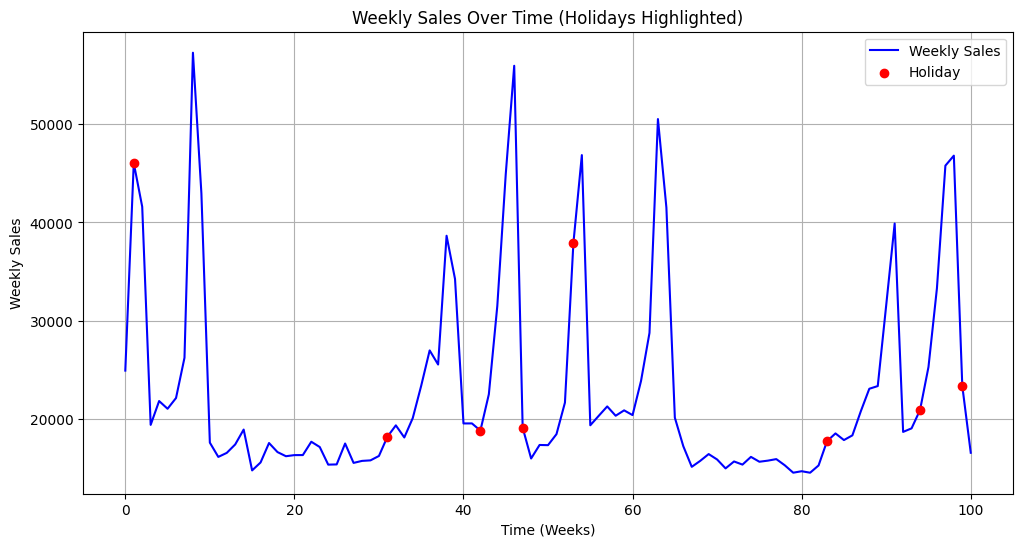

In [33]:
holidays = train_dept_1_1[train_dept_1_1['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
plt.plot(train_dept_1_1['Date'], train_dept_1_1['Weekly_Sales'], label='Weekly Sales', color='blue')
plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()